## DATA 620 - Project 2: Marvel Social Network Universe

**By Eddie Xu and Mohamed Hassan-El Serafi**

For this project:

Instructions:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday 

[Kaggle data link](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

In [1]:
# load packages
import pandas as pd
import numpy as np
import networkx as nx
import random
import movecolumn as mc
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,10)

# import packages to set up bipartite graph and communities
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from community import community_louvain
import matplotlib.cm as cm

### Data Selection

In [2]:
edges_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edges.csv'
network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/hero-network.csv'
nodes_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/nodes.csv' 

# extract data
nodes_raw = pd.read_csv(nodes_url)
edges_raw = pd.read_csv(edges_url)
network_raw = pd.read_csv(network_url)

### Exploratory Data Analysis

#### Nodes

In [3]:
nodes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [4]:
nodes_raw.head(10)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
5      4-D MAN/MERCURIO   hero
6               8-BALL/   hero
7                 A '00  comic
8                 A '01  comic
9                 A 100  comic

In [5]:
nodes_profile = ProfileReport(nodes_raw, title="Nodes Profiling Report")
nodes_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Edges

In [6]:
edges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
edges_raw.head(10)

hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9

In [8]:
edges_profile = ProfileReport(edges_raw, title="Edges Profiling Report")
edges_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Network

In [9]:
network_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [10]:
network_raw.head(10)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.

In [11]:
network_profile = ProfileReport(network_raw, title="Network Profiling Report")
network_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Transformation

In [12]:
# For unipartite graph
# create the hero network
Thor_network = network_raw[network_raw['hero1'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_network = network_raw[network_raw['hero1'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_network = network_raw[network_raw['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_network = network_raw[network_raw['hero1'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_network = network_raw[network_raw['hero1'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger networks into one
network_subset = pd.concat([Thor_network, Cap_network, IronMan_network, BlackWidow_network, Hulk_network],axis = 0)

In [13]:
## for bipartite graph
# create the avenger list
avenger_list = ['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']

# extract edges of original avengers except for hawkeyes as there is no data for it
Thor_edge = edges_raw[edges_raw['hero'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_edge = edges_raw[edges_raw['hero'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_edge = edges_raw[edges_raw['hero'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_edge = edges_raw[edges_raw['hero'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_edge = edges_raw[edges_raw['hero'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger edges into one
edge_subset = pd.concat([Thor_edge, Cap_edge, IronMan_edge, BlackWidow_edge, Hulk_edge],axis = 0)
edge_list = list(zip(edge_subset['hero'], edge_subset['comic']))

# create the comic list
comic_list = edge_subset['comic']

### Network Analysis

#### Unipartite Network

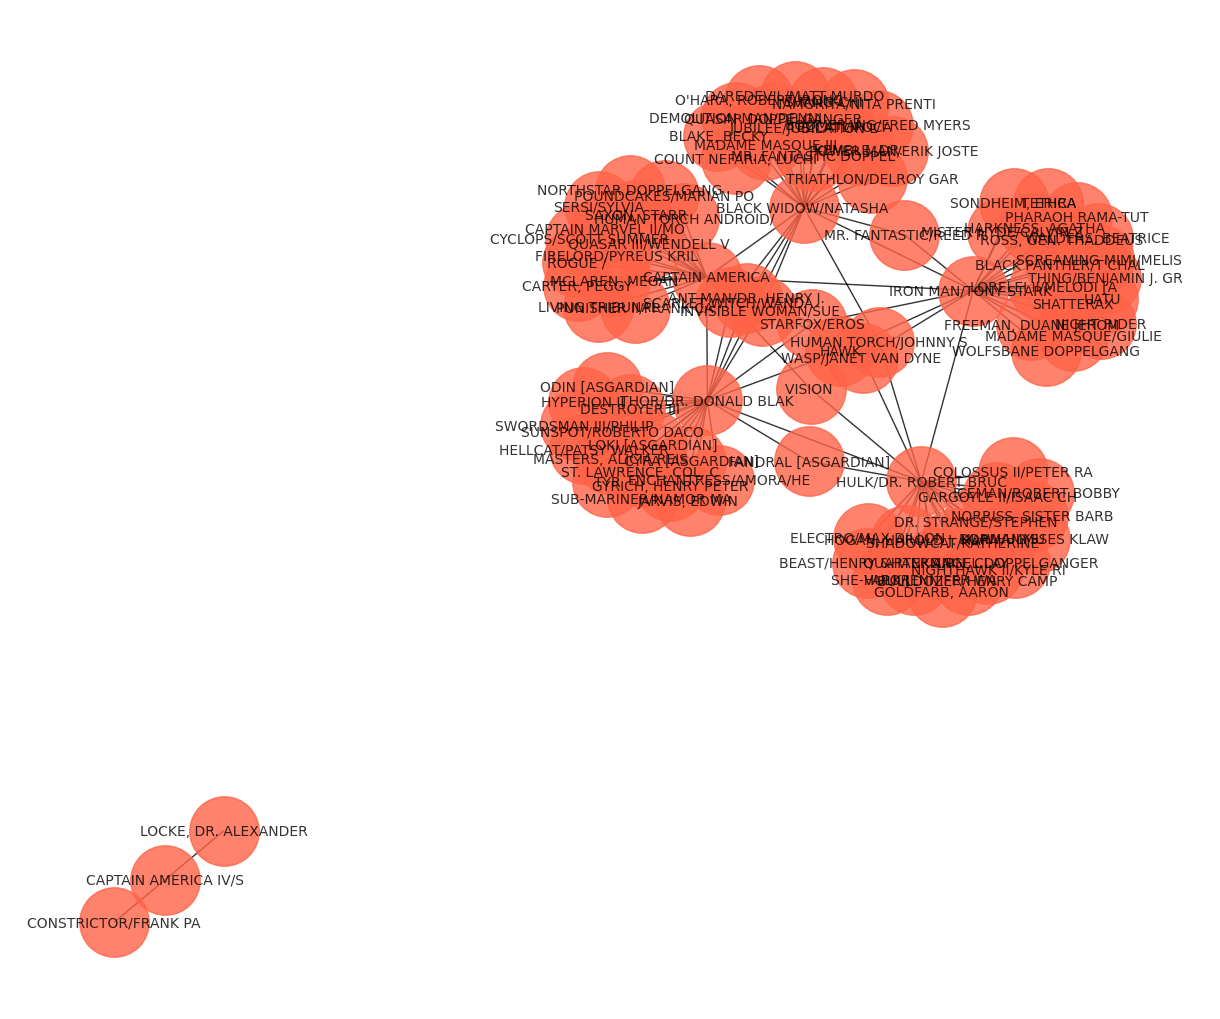

In [14]:
G=nx.from_pandas_edgelist(network_subset, 'hero1', 'hero2')
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="tomato", font_size=10, font_color="black", edge_color="black", alpha=0.8)

plt.show()

#### Network Centrality

### Degree Centrality

In [15]:
# get the degree centrality
avenger_centrality = nx.degree_centrality(G)
sorted_avenger_centrality = sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Degree Centrality:", sorted_avenger_centrality)
sorted_avenger_centrality

Top Avenger by Degree Centrality: [('THOR/DR. DONALD BLAK', 0.24742268041237114), ('HULK/DR. ROBERT BRUC', 0.24742268041237114), ('BLACK WIDOW/NATASHA ', 0.24742268041237114), ('IRON MAN/TONY STARK ', 0.24742268041237114), ('CAPTAIN AMERICA', 0.2268041237113402), ('SCARLET WITCH/WANDA ', 0.030927835051546393), ('STARFOX/EROS', 0.030927835051546393), ('ANT-MAN/DR. HENRY J.', 0.030927835051546393), ('WASP/JANET VAN DYNE ', 0.030927835051546393), ('INVISIBLE WOMAN/SUE ', 0.020618556701030927)]


[('THOR/DR. DONALD BLAK', 0.24742268041237114),
 ('HULK/DR. ROBERT BRUC', 0.24742268041237114),
 ('BLACK WIDOW/NATASHA ', 0.24742268041237114),
 ('IRON MAN/TONY STARK ', 0.24742268041237114),
 ('CAPTAIN AMERICA', 0.2268041237113402),
 ('SCARLET WITCH/WANDA ', 0.030927835051546393),
 ('STARFOX/EROS', 0.030927835051546393),
 ('ANT-MAN/DR. HENRY J.', 0.030927835051546393),
 ('WASP/JANET VAN DYNE ', 0.030927835051546393),
 ('INVISIBLE WOMAN/SUE ', 0.020618556701030927)]

In [16]:
avenger_degree_df = pd.DataFrame(sorted(avenger_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Degree Centrality'])

In [17]:
avenger_degree_df

Name  Degree Centrality
0  THOR/DR. DONALD BLAK           0.247423
1  HULK/DR. ROBERT BRUC           0.247423
2  BLACK WIDOW/NATASHA            0.247423
3  IRON MAN/TONY STARK            0.247423
4       CAPTAIN AMERICA           0.226804
5  SCARLET WITCH/WANDA            0.030928
6          STARFOX/EROS           0.030928
7  ANT-MAN/DR. HENRY J.           0.030928
8  WASP/JANET VAN DYNE            0.030928
9  INVISIBLE WOMAN/SUE            0.020619

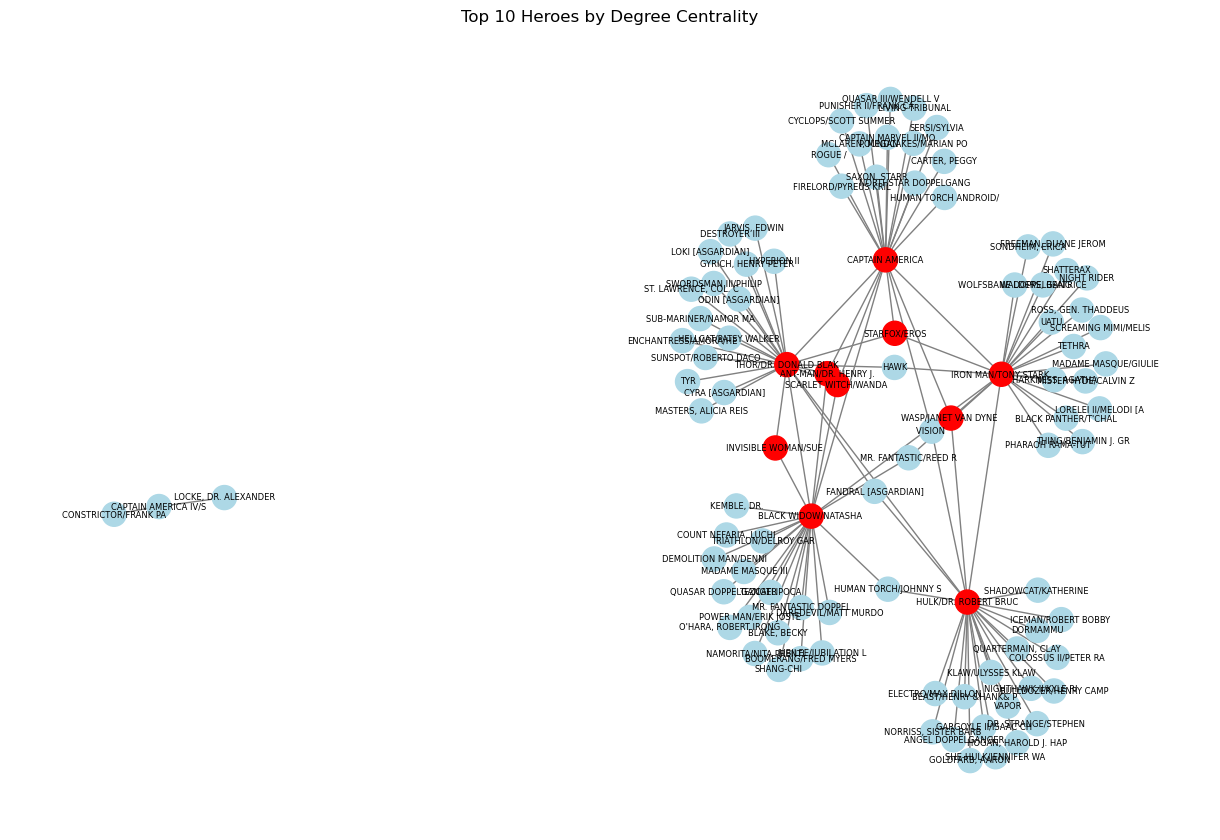

In [18]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes1 = [node for node, _ in sorted_avenger_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes1 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Degree Centrality")
plt.show()

### Betweenness Centrality

In [19]:
# get the betweeness centrality
avenger_betweeness_centrality = nx.betweenness_centrality(G)
sorted_betweeness_centrality = sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Betweeness Centrality:", sorted_betweeness_centrality)
sorted_betweeness_centrality

Top Avenger by Betweeness Centrality: [('IRON MAN/TONY STARK ', 0.36670962199312657), ('HULK/DR. ROBERT BRUC', 0.3537192153493701), ('THOR/DR. DONALD BLAK', 0.3481493413516604), ('BLACK WIDOW/NATASHA ', 0.3298324742268042), ('CAPTAIN AMERICA', 0.2905140320733106), ('HUMAN TORCH/JOHNNY S', 0.02312428407789231), ('VISION ', 0.015302835051546391), ('WASP/JANET VAN DYNE ', 0.015302835051546391), ('STARFOX/EROS', 0.012371134020618563), ('HAWK', 0.012371134020618563)]


[('IRON MAN/TONY STARK ', 0.36670962199312657),
 ('HULK/DR. ROBERT BRUC', 0.3537192153493701),
 ('THOR/DR. DONALD BLAK', 0.3481493413516604),
 ('BLACK WIDOW/NATASHA ', 0.3298324742268042),
 ('CAPTAIN AMERICA', 0.2905140320733106),
 ('HUMAN TORCH/JOHNNY S', 0.02312428407789231),
 ('VISION ', 0.015302835051546391),
 ('WASP/JANET VAN DYNE ', 0.015302835051546391),
 ('STARFOX/EROS', 0.012371134020618563),
 ('HAWK', 0.012371134020618563)]

In [20]:
avenger_betweenness_df = pd.DataFrame(sorted(avenger_betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Betweenness Centrality'])

In [21]:
avenger_betweenness_df

Name  Betweenness Centrality
0  IRON MAN/TONY STARK                 0.366710
1  HULK/DR. ROBERT BRUC                0.353719
2  THOR/DR. DONALD BLAK                0.348149
3  BLACK WIDOW/NATASHA                 0.329832
4       CAPTAIN AMERICA                0.290514
5  HUMAN TORCH/JOHNNY S                0.023124
6               VISION                 0.015303
7  WASP/JANET VAN DYNE                 0.015303
8          STARFOX/EROS                0.012371
9                  HAWK                0.012371

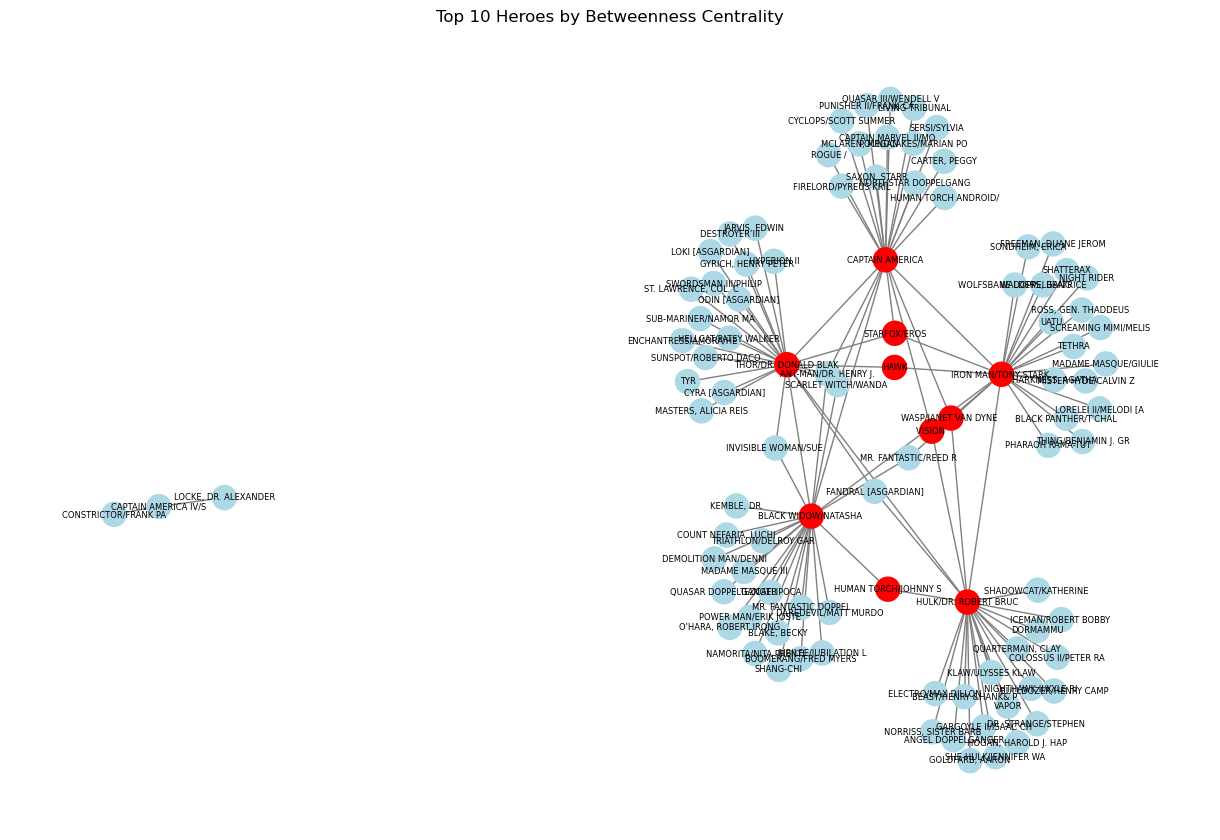

In [22]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes2 = [node for node, _ in sorted_betweeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes2 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Betweenness Centrality")
plt.show()

### Closeness Centrality

In [23]:
# get the closenss centrality
avenger_closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Closeness Centrality:", sorted_closeness_centrality)
sorted_closeness_centrality

Top Avenger by Closeness Centrality: [('IRON MAN/TONY STARK ', 0.5088982318723723), ('THOR/DR. DONALD BLAK', 0.5032750469898046), ('BLACK WIDOW/NATASHA ', 0.5005097994788716), ('CAPTAIN AMERICA', 0.49506947557149267), ('HULK/DR. ROBERT BRUC', 0.46955043043894146), ('WASP/JANET VAN DYNE ', 0.41978241246615045), ('SCARLET WITCH/WANDA ', 0.414058106841612), ('STARFOX/EROS', 0.414058106841612), ('ANT-MAN/DR. HENRY J.', 0.414058106841612), ('FANDRAL [ASGARDIAN]', 0.38928539959467795)]


[('IRON MAN/TONY STARK ', 0.5088982318723723),
 ('THOR/DR. DONALD BLAK', 0.5032750469898046),
 ('BLACK WIDOW/NATASHA ', 0.5005097994788716),
 ('CAPTAIN AMERICA', 0.49506947557149267),
 ('HULK/DR. ROBERT BRUC', 0.46955043043894146),
 ('WASP/JANET VAN DYNE ', 0.41978241246615045),
 ('SCARLET WITCH/WANDA ', 0.414058106841612),
 ('STARFOX/EROS', 0.414058106841612),
 ('ANT-MAN/DR. HENRY J.', 0.414058106841612),
 ('FANDRAL [ASGARDIAN]', 0.38928539959467795)]

In [24]:
avenger_closeness_df = pd.DataFrame(sorted(avenger_closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Closeness Centrality'])

In [25]:
avenger_closeness_df

Name  Closeness Centrality
0  IRON MAN/TONY STARK               0.508898
1  THOR/DR. DONALD BLAK              0.503275
2  BLACK WIDOW/NATASHA               0.500510
3       CAPTAIN AMERICA              0.495069
4  HULK/DR. ROBERT BRUC              0.469550
5  WASP/JANET VAN DYNE               0.419782
6  SCARLET WITCH/WANDA               0.414058
7          STARFOX/EROS              0.414058
8  ANT-MAN/DR. HENRY J.              0.414058
9   FANDRAL [ASGARDIAN]              0.389285

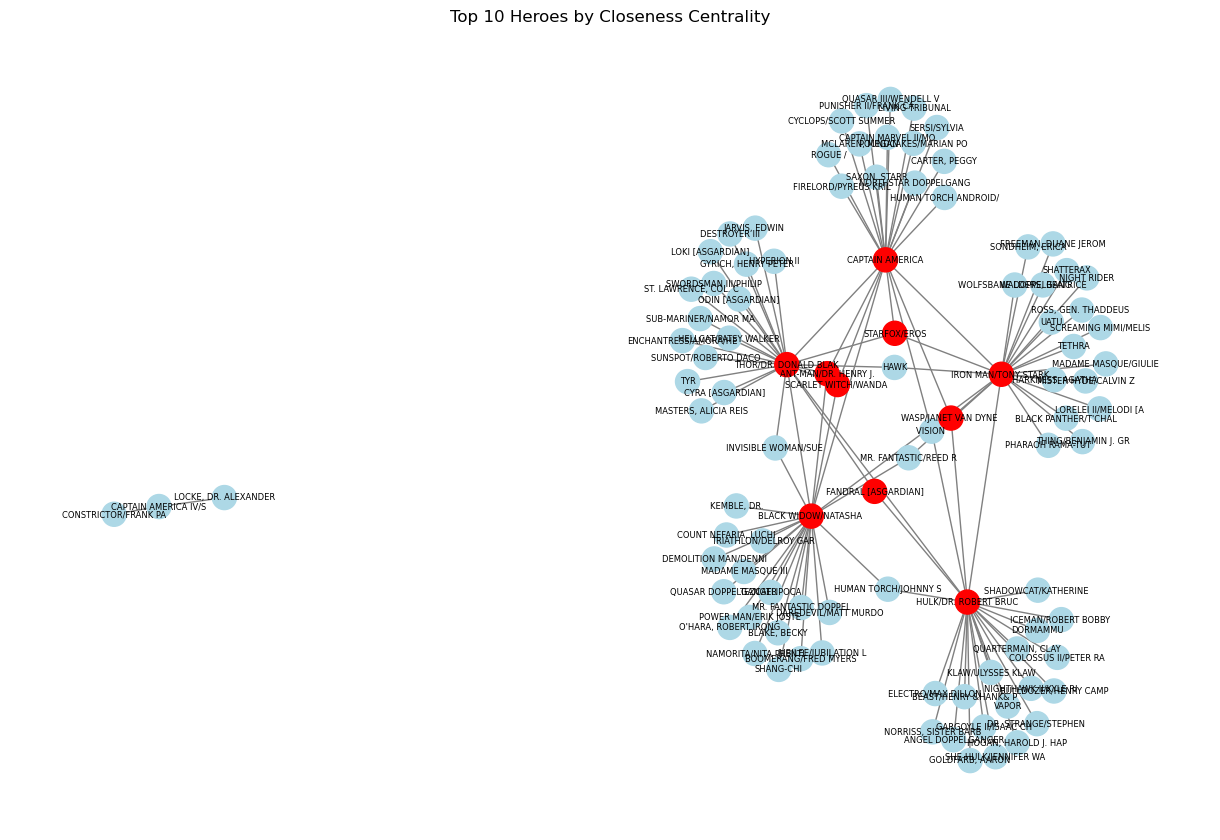

In [26]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes3 = [node for node, _ in sorted_closeness_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes3 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Closeness Centrality")
plt.show()

### Eigenvector Centrality

In [27]:
avenger_eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Eigenvector Centrality:", sorted_eigenvector_centrality)
sorted_eigenvector_centrality

Top Avenger by Eigenvector Centrality: [('THOR/DR. DONALD BLAK', 0.3864137655056593), ('BLACK WIDOW/NATASHA ', 0.3812805941879836), ('CAPTAIN AMERICA', 0.37739449090967786), ('IRON MAN/TONY STARK ', 0.34679353544318775), ('HULK/DR. ROBERT BRUC', 0.2692306193516056), ('SCARLET WITCH/WANDA ', 0.1656815630157833), ('ANT-MAN/DR. HENRY J.', 0.1656815630157833), ('STARFOX/EROS', 0.16069263906636685), ('WASP/JANET VAN DYNE ', 0.14373879685770116), ('INVISIBLE WOMAN/SUE ', 0.11107675095948732)]


[('THOR/DR. DONALD BLAK', 0.3864137655056593),
 ('BLACK WIDOW/NATASHA ', 0.3812805941879836),
 ('CAPTAIN AMERICA', 0.37739449090967786),
 ('IRON MAN/TONY STARK ', 0.34679353544318775),
 ('HULK/DR. ROBERT BRUC', 0.2692306193516056),
 ('SCARLET WITCH/WANDA ', 0.1656815630157833),
 ('ANT-MAN/DR. HENRY J.', 0.1656815630157833),
 ('STARFOX/EROS', 0.16069263906636685),
 ('WASP/JANET VAN DYNE ', 0.14373879685770116),
 ('INVISIBLE WOMAN/SUE ', 0.11107675095948732)]

In [28]:
avenger_eigenvector_df = pd.DataFrame(sorted(avenger_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10], 
                               columns=['Name', 'Eigenvector Centrality'])

In [29]:
avenger_eigenvector_df

Name  Eigenvector Centrality
0  THOR/DR. DONALD BLAK                0.386414
1  BLACK WIDOW/NATASHA                 0.381281
2       CAPTAIN AMERICA                0.377394
3  IRON MAN/TONY STARK                 0.346794
4  HULK/DR. ROBERT BRUC                0.269231
5  SCARLET WITCH/WANDA                 0.165682
6  ANT-MAN/DR. HENRY J.                0.165682
7          STARFOX/EROS                0.160693
8  WASP/JANET VAN DYNE                 0.143739
9  INVISIBLE WOMAN/SUE                 0.111077

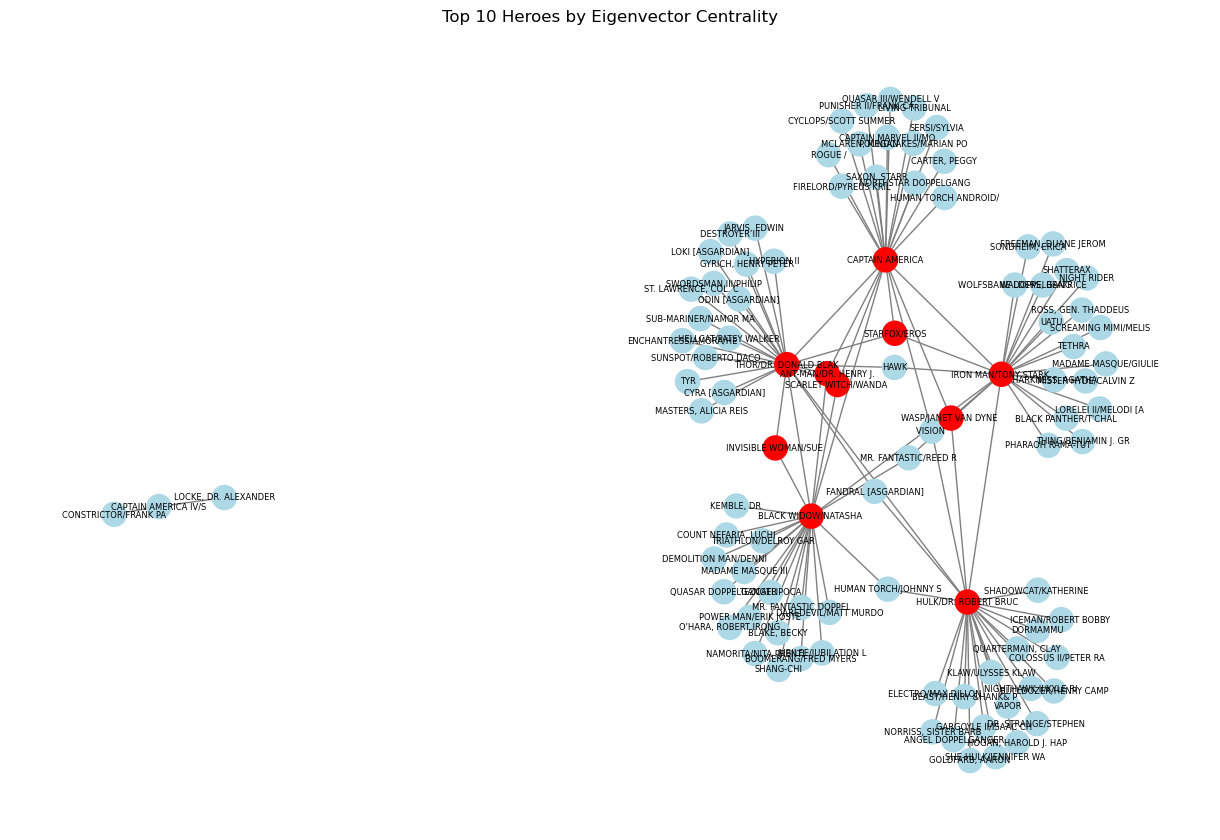

In [30]:
# Extract the top 10 nodes by degree centrality from the sampled graph
top_nodes4 = [node for node, _ in sorted_eigenvector_centrality]

# Assign colors: Highlight top nodes in red, others in blue
node_colors = ["red" if node in top_nodes4 else "lightblue" for node in G.nodes()]

# Plot the network with highlighted top nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=300, font_size=6, font_color="black")

plt.title("Top 10 Heroes by Eigenvector Centrality")
plt.show()

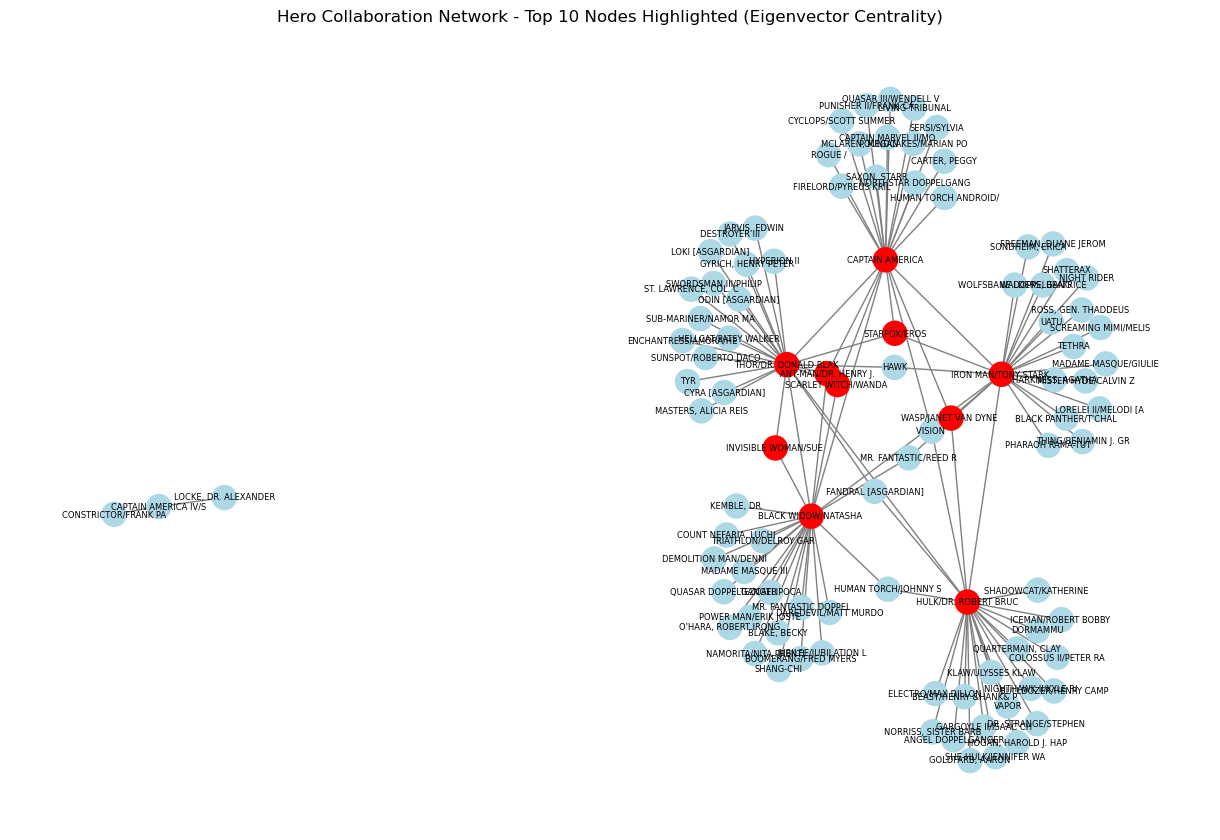

In [31]:
# # Extract the top 5 nodes by degree centrality from the sampled graph
# top_nodes = [node for node, _ in sorted_eigenvector_centrality]

# # Assign colors: Highlight top nodes in red, others in blue
# node_colors = ["red" if node in top_nodes else "lightblue" for node in G.nodes()]

# # Plot the network with highlighted top nodes
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

# nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
#         node_size=300, font_size=6, font_color="black")

# plt.title("Hero Collaboration Network - Top 10 Nodes Highlighted (Eigenvector Centrality)")
# plt.show()

In [32]:
# Assign colors: Highly central events = red, others = lightblue



# clubs_colors = ["red" if node in sorted_avenger_centrality else "lightblue" for node in G.nodes()]

# # Draw the bipartite network
# plt.figure(figsize=(10, 7))
# nx.draw(G, with_labels=True, node_color=clubs_colors, edge_color="gray", node_size=3000, font_size=8, 
#         font_family="Times New Roman")
# plt.title("Most Influential Avengers by Degree Centrality in the Marvel Universe")
# plt.show()

#### Bipartite Network

In [33]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(edge_list)

# check if the graph is bipartite
print(bipartite.is_bipartite(avenger_bipart)) 

bipartite_none = list()
# Examine the bipartite attribute of each node
for node, data in avenger_bipart.nodes(data=True):
    if data.get('bipartite') == None:
        print(f"Node {node}: bipartite = {data.get('bipartite')}")
        bipartite_none.append(node)

True


In [34]:
# remove nodes that have NONE bipartite
avenger_bipart.remove_nodes_from(bipartite_none)

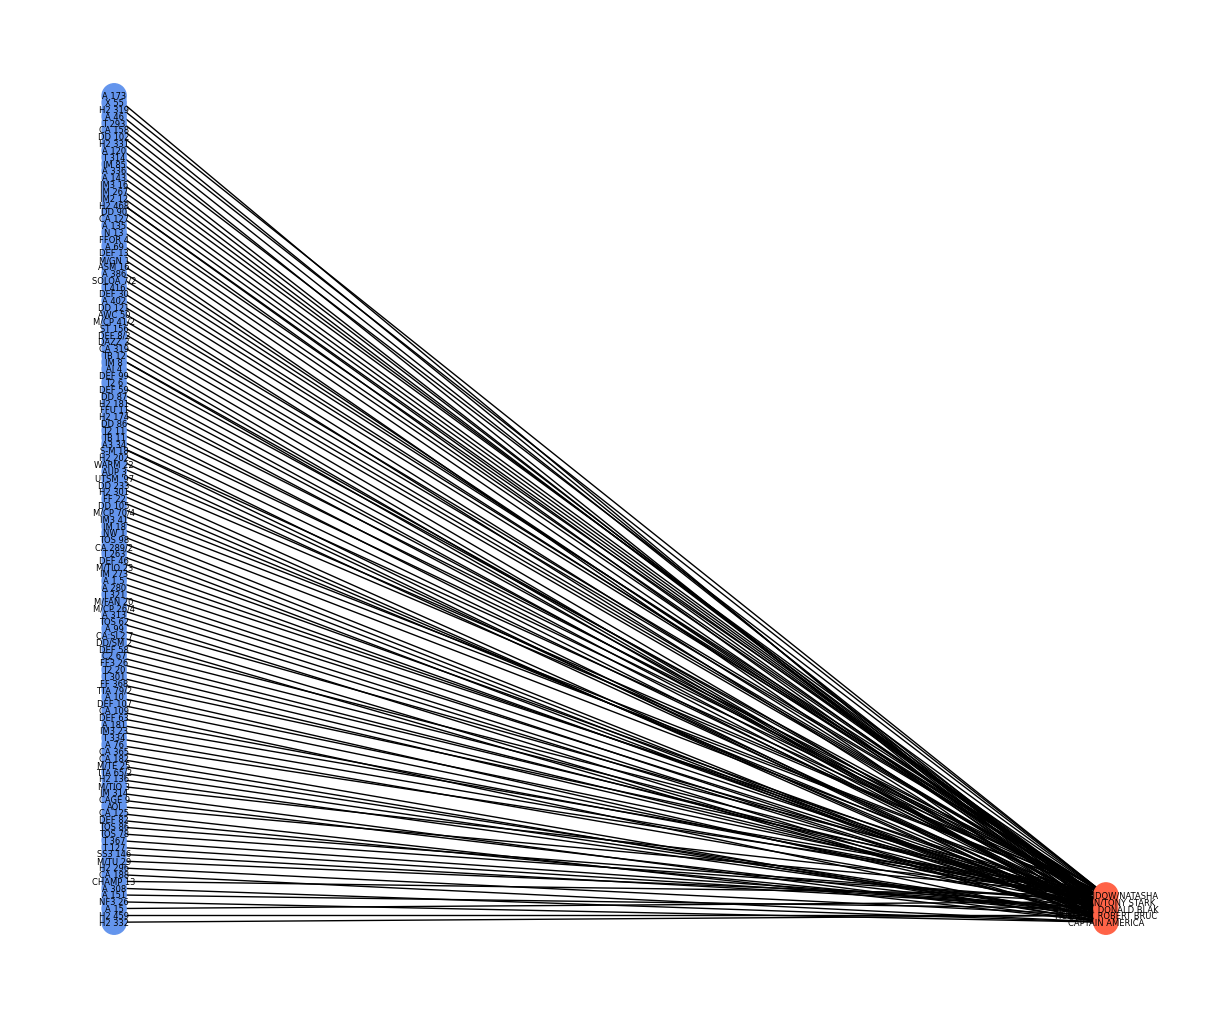

In [35]:
# separate nodes
top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes_subset = set(avenger_bipart) - top_nodes_subset
avenger_bipart.nodes(data=True)

# set node colors
color_dict = {0:'cornflowerblue', 1:'tomato'}
color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# draw a bipartite graph
pos = dict()
color = []
pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6)
plt.show()

In [36]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(edge_list)


In [37]:
# # create the bipartite graph
# avenger_bipart = nx.Graph()

# # add nodes and edges
# avenger_bipart.add_nodes_from(comic_list, bipartite=0)
# avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
# avenger_bipart.add_edges_from(edge_list)

# # separate nodes
# top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
# bottom_nodes_subset = set(avenger_bipart) - top_nodes_subset
# avenger_bipart.nodes(data=True)

# # set node colors
# color_dict = {0:'cornflowerblue', 1:'tomato'}
# color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# # draw a bipartite graph
# pos = dict()
# color = []
# plt.figure(figsize = (20,20))
# pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
# pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
# nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6)
# plt.show()


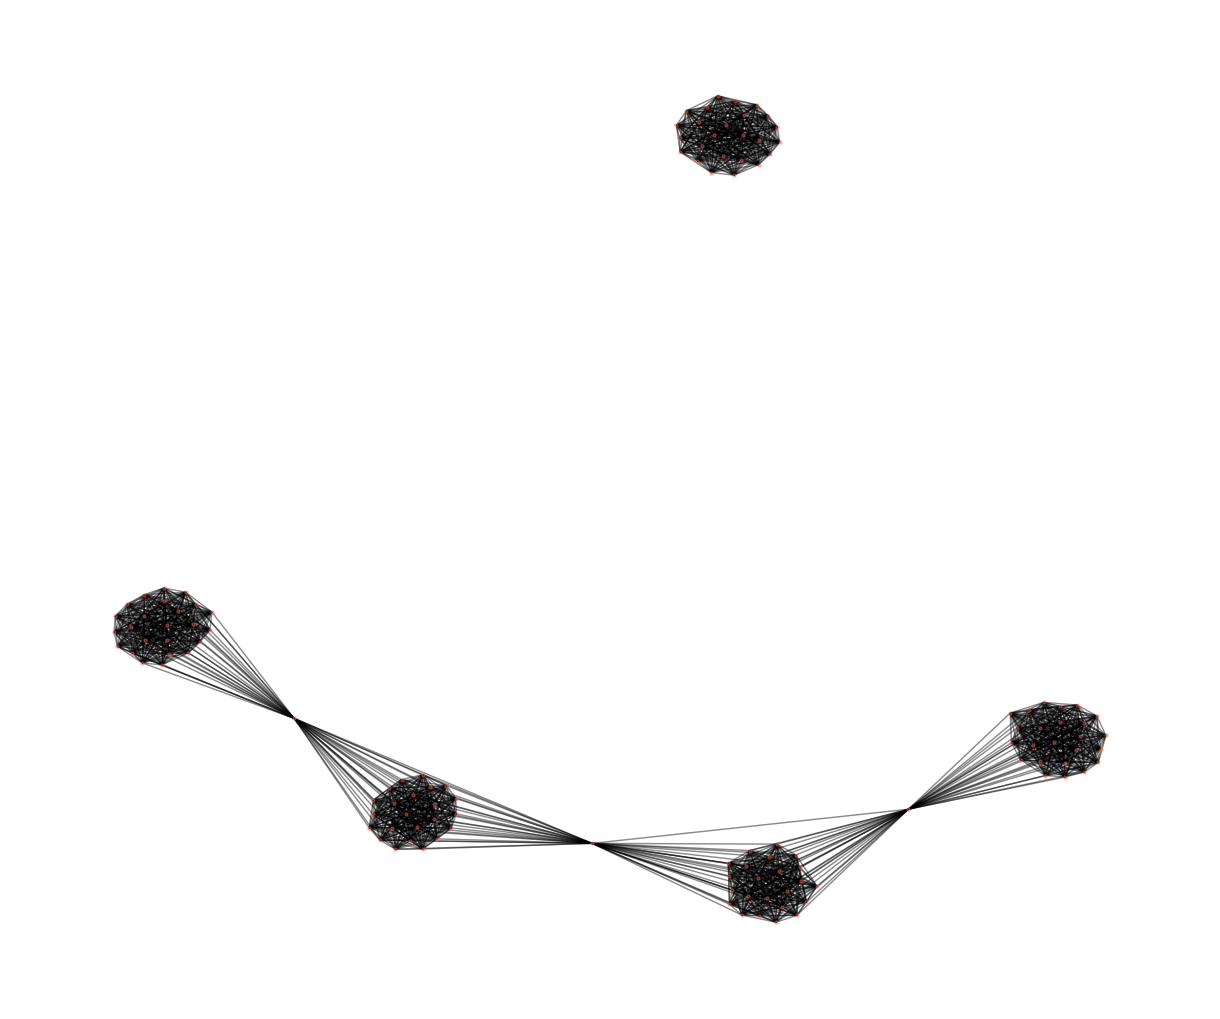

In [38]:
avenger_graph = bipartite.projected_graph(avenger_bipart, comic_list, multigraph=False)

pos=nx.spring_layout(avenger_graph)
nx.draw(avenger_graph, pos=pos, node_size=5, node_color='tomato', alpha=0.4)
nx.draw_networkx_edges(avenger_graph, pos=pos, alpha=0.1)
plt.show()

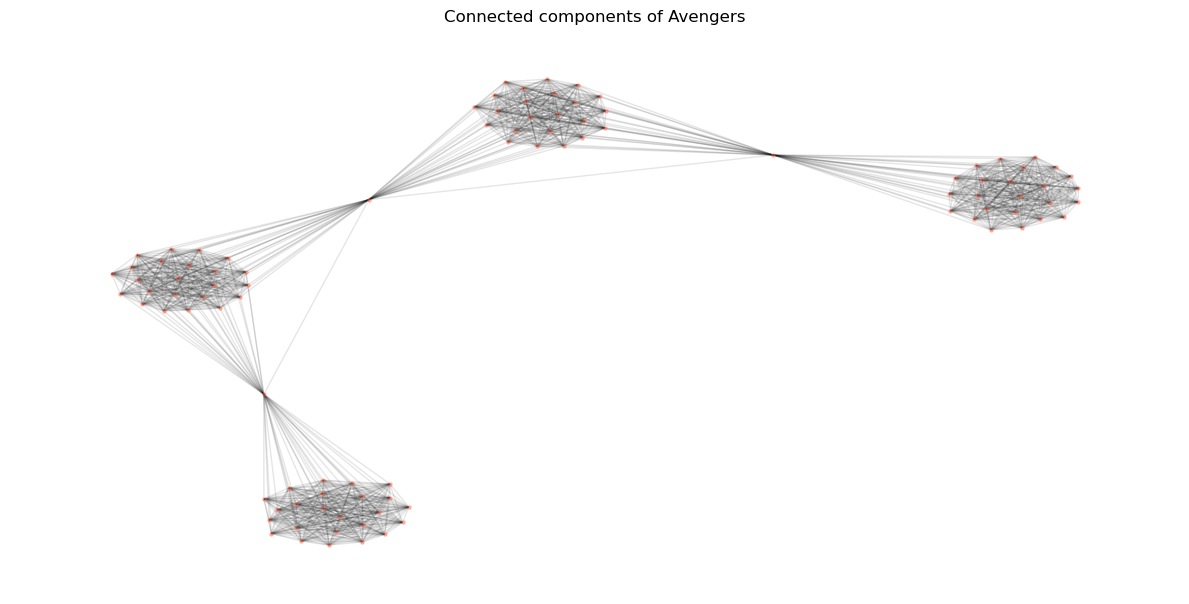

In [39]:
# Ranking of nodes regarding the number of degrees
degree_sequence = sorted([d for n, d in avenger_graph.degree()], reverse=True)

# Extract connected nodes to visualize
Gcc = avenger_graph.subgraph(sorted(nx.connected_components(avenger_graph), key=len, reverse=True)[0])

# Visualization
fig = plt.figure("Degree of the avenger graph")
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Avengers")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

/var/folders/6m/d853x4qs7139b3m7ydxp7jfm0000gn/T/ipykernel_25629/1667474521.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)


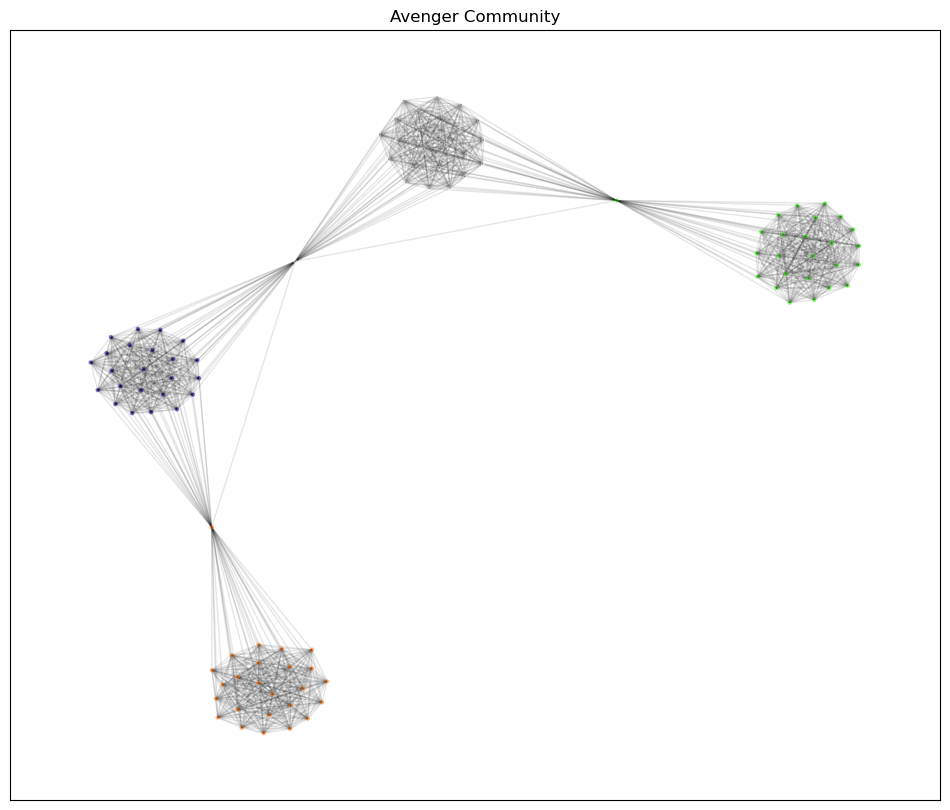

In [40]:
# Community division
partition_avenger = community_louvain.best_partition(Gcc)

# Color the nodes according to community
cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)

pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_avenger.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_avenger.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Avenger Community")
plt.show()

## Key Insights & Observations

When analyzing the top 10 heroes among each centrality measure, a few noteworthy observations stick out. Thor ranks no lower than 3rd in each of the centrality measures, tied for first in degree centrality, ranking first in eigenvector centrality, 2nd in closeness and 3rd in betweenness. Thor's high ranking indicates that this character plays a prominent role in the amount of connections he has, how well-connected he is to other characters that are also well-connected, and being a bridge between and close to other characters. 